<a href="https://colab.research.google.com/github/messias077/REP/blob/main/Problema_Arvores_Decisao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **# Heurística para escolher o melhor valor de cada característica**

In [140]:
# Importes necessários para todos os códigos
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_iris, load_wine, load_breast_cancer
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler

In [141]:
# Carregando a base de dados para a primeira comparação

iris = load_iris()
X, y = iris.data[:,2:], iris.target

In [142]:
# Implementação feita no vídeo

def impureza(y):
    labels = list(set(y))
    labels.sort()
    probabilidades = np.zeros((len(labels),))
    for i,k in enumerate(labels):
        probabilidades[i] = sum(y==k)/len(y)
    result = 1 - sum(probabilidades**2)
    return result


def impurezaValor(x, y, valor):
    maiores = x>valor
    impurezaMaiores = impureza(y[maiores])
    propMaiores = sum(maiores)/len(y)
    impurezaMenores = impureza(y[~maiores])
    propMenores = sum(~maiores)/len(y)
    impurezaTotal = propMaiores*impurezaMaiores + propMenores*impurezaMenores
    return impurezaTotal, impurezaMaiores, impurezaMenores


def melhorValor(x, y):
    menorImpureza = float('inf')
    xmax = np.max(x)
    xmin = np.min(x)
    while True:
        valor = (xmin+xmax)/2
        impTotal, impMaiores, impMenores = impurezaValor(x, y, valor)
        if impTotal < menorImpureza:
            menorImpureza = impTotal
            result = valor
            if impMaiores == 0 or impMenores == 0:
                break
            if impMaiores < impMenores:
                xmin = valor
            else:
                xmax = valor
        else:
            break
    return result, menorImpureza


def melhorCaracteristica(X, y):
    impurezas = []
    valores = []
    for caracteristica in range(X.shape[1]):
        valor, imp = melhorValor(X[:,caracteristica], y)
        impurezas.append(imp)
        valores.append(valor)
    impurezas = np.array(impurezas)
    caracteristica = np.argmin(impurezas)
    return caracteristica, valores[caracteristica], impurezas[caracteristica]


def maisFrequente(y):
    return Counter(y.flat).most_common(1)[0][0]


class Arvore(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        self.caracteristica, self.valor, self.imp = melhorCaracteristica(X, y)
        maiores = X[:,self.caracteristica] > self.valor
        if sum(maiores)>0 and sum(~maiores)>0:
            self.maiores = Arvore()
            self.maiores.fit(X[maiores,:], y[maiores])
            self.menores = Arvore()
            self.menores.fit(X[~maiores,:], y[~maiores])
        else:
            self.resposta = maisFrequente(y)
    def predict(self, X):
        y = np.empty((X.shape[0]))
        if hasattr(self, 'resposta'):
            y[:] = self.resposta
        else:
            maiores = X[:, self.caracteristica] > self.valor
            y[maiores] = self.maiores.predict(X[maiores,:])
            y[~maiores] = self.menores.predict(X[~maiores,:])
        return y

def plotDecisao(modelo, X, y, titulo):
    modelo.fit(X, y)
    x0s = np.linspace(np.min(X[:,0])-0.2, np.max(X[:,0])+0.2, 100)
    x1s = np.linspace(np.min(X[:,1])-0.2, np.max(X[:,1])+0.2, 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    Xdec = np.c_[x0.ravel(), x1.ravel()]
    ypred = modelo.predict(Xdec)
    plt.contourf(x0, x1, ypred.reshape(x0.shape), alpha=0.25)
    for k in set(y):
        plt.plot(X[:,0][y==k], X[:,1][y==k], 'o', label=f"{iris.target_names[k]} [{k}]")
    plt.xlabel(f"X[0]: {iris.feature_names[0]}")
    plt.ylabel(f"X[1]: {iris.feature_names[1]}")
    plt.title(titulo)
    plt.show()

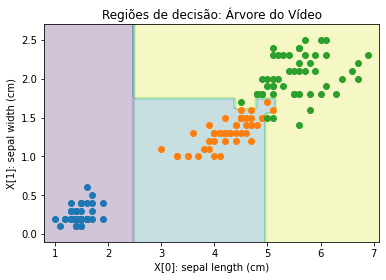

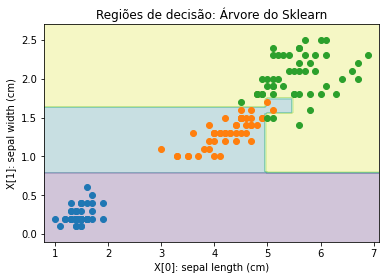

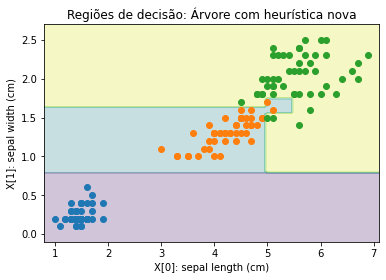

In [143]:
# Comparação das regiões de decisão

plotDecisao(Arvore(), X, y, "Regiões de decisão: Árvore do Vídeo")
plotDecisao(DecisionTreeClassifier(), X, y, "Regiões de decisão: Árvore do Sklearn")
plotDecisao(DecisionTreeClassifier(), X, y, "Regiões de decisão: Árvore com heurística nova") # Repeti o Decision Tree do Sklern só para testes, ainda vou criar a árvore com a heurística

In [144]:
# Comparação utilizando validação cruzada

# Scores árvore do vídeo
scores_video = cross_validate(Arvore(), X, y)
scores_sklearn = cross_validate(DecisionTreeClassifier(), X, y)


print("*** Resultados ***")
print("------------------\n")
print(f"Árvore do vídeo.............: {np.mean(scores_video['test_score'])}")
print(f"Árvore do Sklearn...........: {np.mean(scores_sklearn['test_score'])}")
print(f"Árvore com heurística nova..: {np.mean(scores_sklearn['test_score'])}") # Repeti o Decision Tree do Sklern só para testes, ainda vou criar a árvore com a heurística

*** Resultados ***
------------------

Árvore do vídeo.............: 0.9533333333333334
Árvore do Sklearn...........: 0.9533333333333334
Árvore com heurística nova..: 0.9533333333333334


In [145]:
# Carregando a base de dados para a segunda comparação

# Informações sobre o dataset: https://www.kaggle.com/c/dat31-shuttle/data
# Local onde baixei: https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass.html
# Obs.: Tive que tratar os dados, pois não vieram no formato csv. Também haviam valores 'NaN'
dados1 = pd.read_csv('shuttle.csv')

# Separando em features e target
X1 = df.iloc[:, 1:].values # Retira a coluna 'target'. Fica com as features de 1 a 9
y1 = df.iloc[:, 0].values # Pega somente a coluna 'target'

dados2 = load_breast_cancer()
X2 = data.data
y2 = data.target

dados3 = load_wine()
X3 = data.data
y3 = data.target

# Padronizando os dados das bases
scaler = StandardScaler()
X1 = scaler.fit_transform(X1)
X2 = scaler.fit_transform(X2)
X3 = scaler.fit_transform(X3)

In [146]:
# Para facilitar a execução dos algoritmos
dados = [(X1, y1, 'Shuttle'), (X2, y2, 'Breast cancer'), (X3, y3, 'Wine')]

classificadores = [(Arvore(), 'Árvore do vídeo'), 
                   (DecisionTreeClassifier(), 'Árvore do Sklearn'),
                   (DecisionTreeClassifier(), 'Árvore com heurística nova')] # Repeti o Decision Tree do Sklern só para testes, ainda vou criar a árvore com a heurística

In [147]:
# Faz as comparações utilizando a validação cruzada

print("       *** Resultados ***")
print("       ------------------\n")

# Roda todos os datasets para cada um dos classificadores
for d in dados:
    print(f'- Dataset..........: {d[2]}')

    for c in classificadores:
        scores = cross_validate(c[0], d[0], d[1])
        print(f"  Classificador....: {c[1]}")
        print(f"  Acurácia média...: {np.mean(scores['test_score'])}\n")

    print('\n')

       *** Resultados ***
       ------------------

- Dataset..........: Shuttle
  Classificador....: Árvore do vídeo
  Acurácia média...: 0.99924888414318

  Classificador....: Árvore do Sklearn
  Acurácia média...: 0.9995540236686716

  Classificador....: Árvore com heurística nova
  Acurácia média...: 0.9995305522451297



- Dataset..........: Breast cancer
  Classificador....: Árvore do vídeo
  Acurácia média...: 0.9191429902189101

  Classificador....: Árvore do Sklearn
  Acurácia média...: 0.919111939139885

  Classificador....: Árvore com heurística nova
  Acurácia média...: 0.9156031672100605



- Dataset..........: Wine
  Classificador....: Árvore do vídeo
  Acurácia média...: 0.9191429902189101

  Classificador....: Árvore do Sklearn
  Acurácia média...: 0.915618692749573

  Classificador....: Árvore com heurística nova
  Acurácia média...: 0.9191119391398852





# **Interpretação dos resultados**

Aqui será escrito o parágrafo com a interpretação dos resultados obtidos.